# Introduction to Regularized Regression Methods

# <font color=red> Last class:

## Part I: Post-Inference Problem
    
    - Simulation study to show that the type-I error rate inflates when the same data is used to select a model and make inference
    
    - Proposed a solution: split the data


# <font color=red> Today:

## Part II: how to select and train models at once
       
    - Regularized methods
    
    - Predictive models

In previous worksheets we learned how to select a model using *stepwise* algorithms

- these are *greedy* algorithms 

- results depend on the order in which variables are selected 

- variables are either *in* or *out*

#### If we can think *out* as the estimated coefficient being $0$, can we *smoothly* shrink the estimator instead of selecting between a value and $0$?

Let's illustrate idea this with data:

## Dataset

In this section we will work with a richer real estate dataset, the [Ames `Housing` dataset](https://www.kaggle.com/c/home-data-for-ml-course/), compiled by Dean De Cock. It has 79 input variables on different characteristics of residential houses in Ames, Iowa, USA that can be used to predict the property's final price, `SalePrice`. We will use a subset of 21 continuous input variables:

- `LotFrontage`: Linear $\text{ft}$ of street connected to the house.
- `LotArea`: Lot size in $\text{ft}^2$.
- `MasVnrArea`: Masonry veneer area in $\text{ft}^2$.
- `TotalBsmtSF`: Total $\text{ft}^2$ of basement area.
- `GrLivArea`: Above grade (ground) living area in $\text{ft}^2$.
- `BsmtFullBath`: Number of full bathrooms in basement.
- `BsmtHalfBath`: Number of half bathrooms in basement.
- `FullBath`: Number of full bathrooms above grade.
- `HalfBath`: Number of half bathroom above grade.
- `BedroomAbvGr`: Number of bedrooms above grade (it does not include basement bedrooms).
- `KitchenAbvGr`: Number of kitchens above grade.
- `Fireplaces`: Number of fireplaces.
- `GarageArea`: Garage's area in $\text{ft}^2$.
- `WoodDeckSF`: Wood deck area in $\text{ft}^2$.
- `OpenPorchSF`: Open porch area in $\text{ft}^2$.
- `EnclosedPorch`: Enclosed porch area in $\text{ft}^2$.
- `ScreenPorch`: Screen porch area in $\text{ft}^2$.
- `PoolArea`: Pool area in $\text{ft}^2$.

The following variables will be used to construct a variable `ageSold`
- `YearBuilt`: Original construction date.
- `YrSold`: Year sold.

Run this code to prepare a working dataset

In [1]:
library(broom)
library(latex2exp)
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)

options(repr.plot.width=7, repr.plot.height=6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ dials        1.2.0     ✔ rsample      1.2.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ recipes      1.0.8     ✔ yardstick    1.2.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter

In [2]:
Housing <- read_csv("data/Housing.csv")

# Use `YearBuilt` and `YrSold` to create a variable `ageSold`
Housing$ageSold <- Housing$YrSold - Housing$YearBuilt


# Select subset of input variables
Housing <- Housing %>%
  select(LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, 
    GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, Fireplaces,
    GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolArea, ageSold, SalePrice
  )

# Remove those rows containing `NA`s and some outliers
Housing <- drop_na(Housing)  %>% 
            filter(LotArea < 20000)

Rows: 1460 Columns: 81
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (43): MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConf...
dbl (38): Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, Ye...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#run this cell
set.seed(1234)

Housing_split <- initial_split(Housing, prop = 0.6, strata = SalePrice)
training_Housing <- training(Housing_split)
testing_Housing <- testing(Housing_split)

#### In the following example, I use only the first 5 covariates to simplify the presentation

Run these cells to fit the "forward" selection algorithm on this (smaller) training set:

In [5]:
Housing_forward_sel <- regsubsets(
  x = SalePrice ~ ., nvmax = 19,
  data = training_Housing[,c(1:5,20)],
  method = "forward",
)

In [6]:
summary(Housing_forward_sel)[[1]]

coef(Housing_forward_sel,1)
coef(Housing_forward_sel,2)

,(Intercept),LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,GrLivArea
1,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE
2,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE
3,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
4,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


(Intercept)   GrLivArea 
   816.3893    119.0938

(Intercept)  TotalBsmtSF    GrLivArea 
-40522.44180     83.88263     88.12881

The estimated coefficient for `TotalBsmtSF` "jumps" from 0 to 83.88. Similarly for other coefficients in other steps. 

### Can the selection be done more "smoothly"??

## Shrinkage (aka regularization) methods!!

They shrink coefficients in a continuous way by adding a bound to their size!! We'll focus on 2 methods (there are many other penalty functions one can use!):


- **Ridge** uses an $L_2-$norm to measure the size of the coefficients $$\lVert \beta \rVert_2^2 = \sum_{j = 1}^{p} \beta_j^2.$$


- **Lasso** uses an $L_1-$norm to measure the size of the coefficients $$\lVert \beta \rVert_1 = \sum_{j = 1}^{p} |\beta_j|.$$


This "shrinkage" process biases the estimated coefficients!

- we sacrifice bias for a lower variance to gain prediction performance!!

> **Important:** since the method depend on the *size* of the coefficients, we need to standardize the input variables (default option)

#### Geometrically:

![](img/shrink.png)

### Ridge

- Proposed in 1970 by Hoerl, A.E. and Kennard, R. in \emph{Technometrics}


- It does not shrink parameters to $0$, so it does *not* select variables 


- It has been proposed as a method to address multicollinearity problems (we'll skip the math)


### LASSO: least absolute shrinkage and selection operator

- Proposed in 1996 by Tibshirani in \emph{JRSS}


- **Lasso** uses an $L_1-$norm to measure the size of the coefficients $$\lVert \beta \rVert_1 = \sum_{j = 1}^{p} |\beta_j|.$$


- it *does* shrink coefficients to $0$, thus it can be used to *simultaneously select and train (estimate)* a model!!

#### Mathematically:

**Example**: Ridge estimators 

$$
\ \min_{\beta_0, \boldsymbol{\beta}} \ \sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2
$$
#### subject to
$$
\sum_{j=1}^p \, \beta_j^2 \ \le \ C \; \text{ for some } C > 0.
$$


This is mathematically equivalent to minimizing a *penalized* RSS:

$$
\sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2 + \ \lambda \ \sum_{j=1}^p \, \beta_j^2 \
$$

#### How much to shrink?? the penalty parameter

- The additional term $\lambda \sum_{j = 1}^{p} \beta_j^2$ is the *penalty* term, and $\lambda$ is called the *penalty parameter*. 


- If $\lambda = 0$, the objective function of the shrinkage methods is the same as that of LS!! Same estimators!! 



- As $\lambda$ grows, coefficients are shrunk. 

    - LASSO eventually shrinks them all to zero 
    - Ridge will never reach a value of zero 
    
    
- The penalty parameter $\lambda$ can be selected using the data. This process is called "tuning".

    - an option is to select the value that yields the smallest $\text{MSE}_{\text{test}}$. 
    - this tuning is done using an internal cross-validation or a validation set so that the model does not use *test* data

### In R:

To build a regularized regression we can use the package `glmnet` in `R`

1. the `glmnet()` function requires: a **matrix** with input variables and a vector of responses

2. the argument `alpha = 1` corresponds to a LASSO penalty and `alpha = 0` for a Ridge penalty 

> There are infinite other options in between known as *Elastic Net* 

3. `glmnet()` selects a grid of $\lambda$ values by default or you can specify one

4. it is recommended to use given extraction fuctions to obtain the objects, e.g., estimated coefficients 

5. the function `cv.glmnet()` can be used to find an "optimal" value of $\lambda$ by cross-validation

> CV creates many *test sets* from the training set (we'll see CV later)

6. we can visualize how the estimated test MSE changes for different values of $\lambda$

Run the code below to perform these steps

In [7]:
# step 1: using matrices

Housing_X_train <- as.matrix(training_Housing[,-20])
Housing_Y_train <- as.matrix(training_Housing[,20])

Housing_X_test <- as.matrix(testing_Housing[,-20])
Housing_Y_test <- as.matrix(testing_Housing[,20])

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


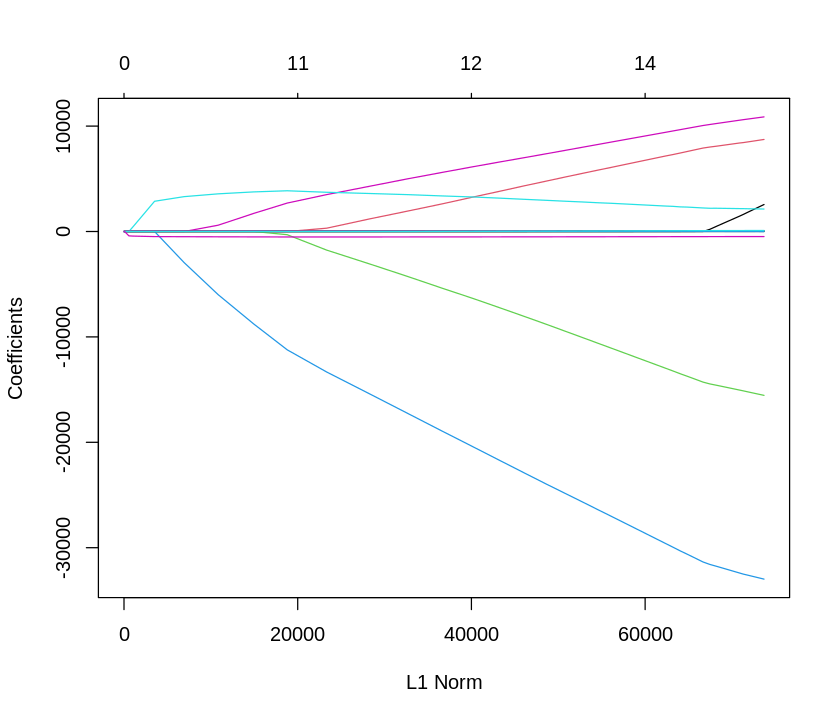

In [8]:
# step 2 and 3: fitting LASSO on a given grid (try using the default as well)

Housing_LASSO <- glmnet(
  x = Housing_X_train, y = Housing_Y_train,
  alpha = 1,
  lambda = exp(seq(5, 12, 0.1))
)

plot(Housing_LASSO)

In [9]:
print(Housing_LASSO)


Call:  glmnet(x = Housing_X_train, y = Housing_Y_train, alpha = 1, lambda = exp(seq(5,      12, 0.1))) 

   Df  %Dev Lambda
1   0  0.00 162800
2   0  0.00 147300
3   0  0.00 133300
4   0  0.00 120600
5   0  0.00 109100
6   0  0.00  98720
7   0  0.00  89320
8   0  0.00  80820
9   0  0.00  73130
10  0  0.00  66170
11  0  0.00  59870
12  1  8.61  54180
13  2 17.17  49020
14  2 26.39  44360
15  3 34.92  40130
16  3 41.94  36320
17  4 48.49  32860
18  4 53.88  29730
19  4 58.28  26900
20  4 61.89  24340
21  4 64.85  22030
22  4 67.27  19930
23  4 69.25  18030
24  4 70.87  16320
25  4 72.20  14760
26  4 73.28  13360
27  6 74.25  12090
28  6 75.11  10940
29  6 75.82   9897
30  6 76.40   8955
31  8 77.04   8103
32  9 77.66   7332
33  9 78.22   6634
34 10 78.73   6003
35 11 79.37   5432
36 11 79.91   4915
37 11 80.35   4447
38 12 80.75   4024
39 12 81.07   3641
40 13 81.34   3294
41 13 81.57   2981
42 14 81.75   2697
43 14 81.91   2441
44 14 82.04   2208
45 14 82.15   1998
46 14 82.24   1808
4

In [14]:
#step 4: extracting estimated coefficients for a given level of regularization
coef(Housing_LASSO, s = 40000)

20 x 1 sparse Matrix of class "dgCMatrix"
                        s1
(Intercept)   1.116881e+05
LotFrontage   .           
LotArea       .           
MasVnrArea    .           
TotalBsmtSF   1.447926e+01
GrLivArea     3.126415e+01
BsmtFullBath  .           
BsmtHalfBath  .           
FullBath      .           
HalfBath      .           
BedroomAbvGr  .           
KitchenAbvGr  .           
Fireplaces    .           
GarageArea    9.785771e+00
WoodDeckSF    .           
OpenPorchSF   .           
EnclosedPorch .           
ScreenPorch   .           
PoolArea      .           
ageSold       .           

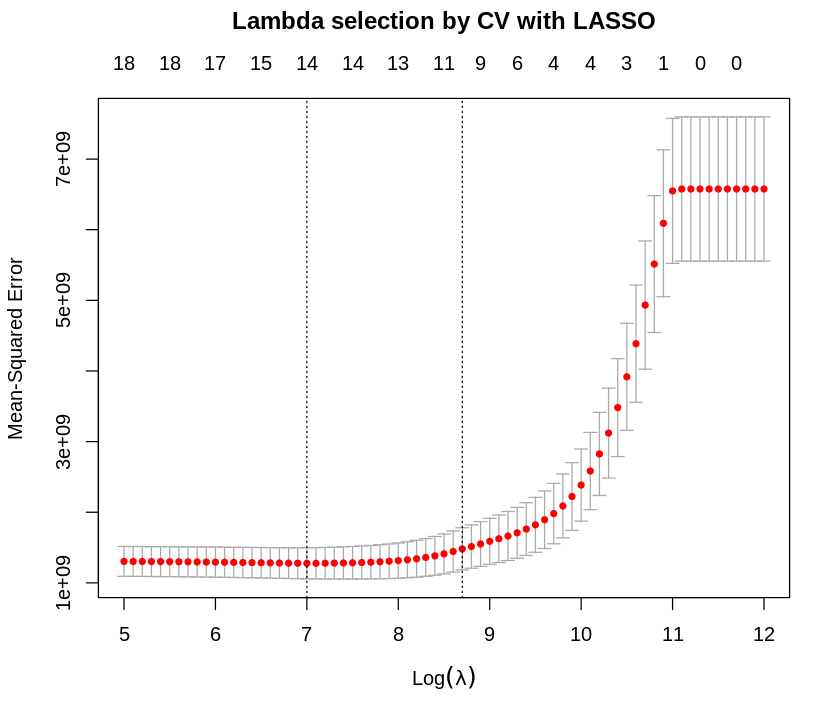

In [10]:
# step 5: selecting best lambda by CV

Housing_cv_LASSO <- cv.glmnet(
  x = Housing_X_train, y = Housing_Y_train,
  alpha = 1,
  lambda = exp(seq(5, 12, 0.1))
)

plot(Housing_cv_LASSO, main = "Lambda selection by CV with LASSO\n\n")

The plot shows the *estimated* test $\text{MSE}$ ($y$-axis) for a grid of values of $\lambda$ ($x$-axis) on the natural log-scale. 

> the numbers at the top $x$-axis indicate the number of inputs whose estimated coefficients are different from zero for different values of $\lambda$. 

> the error bars represent the variation across the different test sets of the CV (folds)

The two vertical dotted lines correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the minimum MSE in the grid.


- $\hat{\lambda}_{\text{1SE}}$ largest value of lambda such that the corresponding MSE is within 1 standard error of that of the minimum (more penalization at a low cost)

Run the code below to obtain $\hat{\lambda}_{\text{min}}$ and call it `Housing_lambda_min_MSE_LASSO`

In [11]:
Housing_lambda_min_LASSO <- round(Housing_cv_LASSO$lambda.min, 4)

round(Housing_lambda_min_LASSO,2)
round(log(Housing_lambda_min_LASSO),2)

[1] 1096.63

[1] 7

#### LASSO "smoothly" selects variables and trains the corresponding model !

> for values of lambda in the grid

Run the code below to visualize the estimated regression coefficients over the $\lambda$-grid

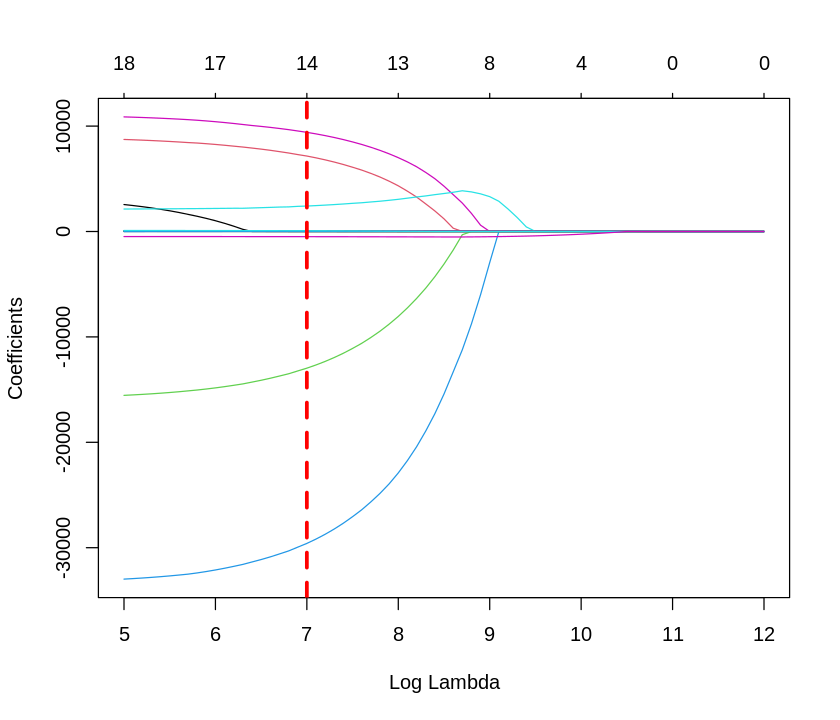

In [12]:
plot(Housing_cv_LASSO$glmnet.fit, "lambda")
abline(v = log(Housing_lambda_min_LASSO), col = "red", lwd = 3, lty = 2)

We can compare the coefficients of the selcted model (for $\hat{\lambda}_{\text{min}}$) with those of the full LS

In [13]:
set.seed(1234)

# Full LS
Housing_full_OLS <- lm(SalePrice ~ .,
data = training_Housing
)

# LASSO
Housing_LASSO_min <- coef(Housing_cv_LASSO, s = "lambda.min")

Housing_reg_coef <- round(cbind(
  Full_OLS = coef(Housing_full_OLS),
  LASSO_min = Housing_LASSO_min), 4)

Housing_reg_coef

20 x 2 sparse Matrix of class "dgCMatrix"
                 Full_OLS          s1
(Intercept)    45822.7774  44109.5208
LotFrontage       27.2866      .     
LotArea            1.9631      1.7403
MasVnrArea        36.6718     32.5969
TotalBsmtSF       36.9469     37.9546
GrLivArea         82.9417     80.9013
BsmtFullBath   11144.9818   9407.9130
BsmtHalfBath    3482.7632      .     
FullBath        9165.1128   7159.1181
HalfBath         290.2871      .     
BedroomAbvGr  -15968.2776 -12964.7247
KitchenAbvGr  -33430.6905 -29590.9030
Fireplaces      2092.4632   2414.9024
GarageArea        44.8185     46.5876
WoodDeckSF        14.5117     10.5983
OpenPorchSF       34.9419     20.0826
EnclosedPorch      7.4118      .     
ScreenPorch      -15.0181      .     
PoolArea         100.2163     73.2391
ageSold         -481.2720   -489.9599

Finally, we can use the trained LASSO model to predict the response of the test set!!

Run the code below to compare the prediction performance of LS with those of LASSO in the test set

In [14]:
# Full LS predictions

Housing_test_pred_full_OLS <- predict(Housing_full_OLS, newdata = testing_Housing)

In [15]:
# LASSO predictions with lambda.min

Housing_test_pred_LASSO_min <- predict(Housing_cv_LASSO, 
                                       newx = Housing_X_test, 
                                       s = "lambda.min")

In [16]:
# Comparison

Housing_R_MSE_models <- rbind(tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = Housing_test_pred_full_OLS,
    actuals = testing_Housing$SalePrice
  )
),
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = Housing_test_pred_LASSO_min,
      actuals = testing_Housing$SalePrice
    )
  )
)

Housing_R_MSE_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,31397.47
LASSO Regression with minimum MSE,31340.37


#### In this example the full LS model has slightly worse prediction performance than LASSO

> results may depend on the split of the data. We need to make several splits to assess these models

## Can we use LASSO for inference??

In the second part of worksheet 10 you will examine this question.